## Qualitative change detection - vegetation changes in Redlands after 2015 El Nino

Import library and search for Landsat imagery layer

<Item title:"Multispectral Landsat" type:Imagery Layer owner:esri_livingatlas>
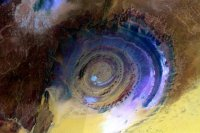

In [41]:
from arcgis.gis import GIS
gis = GIS('https://python.playground.esri.com/portal', 'arcgis_python', 'amazing_arcgis_123')
landsat_item = gis.content.search('Multispectral Landsat', 'Imagery Layer', outside_org=True)[0]
landsat = landsat_item.layers[0]
landsat_item

### Select images of Redlands area

In [42]:
from arcgis.geocoding import geocode
area = geocode('Redlands, CA', out_sr=landsat.properties.spatialReference)[0]

In [50]:
import arcgis
selected = landsat.filter_by(where="CloudCover <=0.10", 
                   geometry=arcgis.geometry.filters.intersects(area['extent']))

You can query the filtered rasters as a FeatureSet:

In [46]:
fs = selected.query(out_fields="AcquisitionDate, CloudCover, WRS_Row, WRS_Path", 
              return_geometry=True,
              return_distinct_values=False,
              order_by_fields="AcquisitionDate")

Attributes of the selected rasters can be queried using a Pandas dataframe using the 'df' property of the FeatureSet.

In [65]:
import pandas as pd
df = fs.df
df['Time'] = pd.to_datetime(df['AcquisitionDate'], unit='ms')
df[(df['Time'] > '2015-07') & (df['Time'] <'2016-05')]

,AcquisitionDate,CloudCover,OBJECTID,Shape_Area,Shape_Length,WRS_Path,WRS_Row,SHAPE,Time
17,1436984502287,0.0034,141162,5.135278e+10,906869.659682,40,36,"{'rings': [[[-12865050.9115, 4199551.647500001...",2015-07-15 18:21:42.287
18,1438366906361,0.0311,153033,5.135268e+10,906868.766567,40,36,"{'rings': [[[-12863500.5111, 4199529.073600002...",2015-07-31 18:21:46.361
19,1439749312663,0.0045,160262,5.135266e+10,906868.596576,40,36,"{'rings': [[[-12863215.7466, 4199524.9036], [-...",2015-08-16 18:21:52.663
20,1441131717891,0.0444,166025,5.136519e+10,906973.248614,40,36,"{'rings': [[[-12862989.3834, 4199521.189900003...",2015-09-01 18:21:57.891
21,1442514126299,0.0071,174014,5.135275e+10,906869.452853,40,36,"{'rings': [[[-12864683.8771, 4199546.323200002...",2015-09-17 18:22:06.299
22,1443896530361,0.0059,182444,5.136531e+10,906974.321638,40,36,"{'rings': [[[-12864824.5461, 4199547.971500002...",2015-10-03 18:22:10.361
23,1448043737835,0.0144,207506,5.250596e+10,916751.218356,40,36,"{'rings': [[[-12861584.4287, 4198640.915600002...",2015-11-20 18:22:17.835
24,1454955729355,0.0161,298658,5.137456e+10,907060.468588,40,36,"{'rings': [[[-12864564.0423, 4199399.239799999...",2016-02-08 18:22:09.355
25,1456338122999,0.0125,257053,5.255131e+10,917136.783478,40,36,"{'rings': [[[-12860933.7768, 4198654.620399997...",2016-02-24 18:22:02.999
26,1459102911403,0.0966,283786,5.136752e+10,907008.188067,40,36,"{'rings': [[[-12865356.1673, 4199553.7522], [-...",2016-03-27 18:21:51.403


### Change Detection

In [58]:
summer_2015 = landsat.filter_by('OBJECTID=160262')
spring_2016 = landsat.filter_by('OBJECTID=278577')

#### NDVI diff

In [64]:
ndvi_diff = ndvi(spring_2016, '5 4') - ndvi(summer_2015, '5 4')

#### Remap NDVI and apply a colormap

In [66]:
threshold = 0.1
ndvi_diff_remap = remap(ndvi_diff, input_ranges=[threshold, 1], output_values=[1],
                       no_data_ranges=[-1, threshold], astype='u8')

ndvi_diff_colormap = colormap(ndvi_diff_remap, colormap=[[1, 124, 252, 0]], astype='u8')

The difference image and threshold mask can be visualized using the map widget:

In [67]:
redlands_map = gis.map('Redlands, CA')
redlands_map.basemap='satellite'
redlands_map

In [69]:
redlands_map.add_layer(ndvi_diff_colormap)